In [119]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt

In [120]:
# Index symbols
#Dow Jones Industrial Average - DJI
#S&P 500 - GSPC
#NASDAQ Composite - IXIC

sdate = "2015-01-01"
edate = "2023-12-31"
symbols = ['^DJI','^GSPC','^IXIC']

# Download data from yahoo finance
dfs = []
for symbol in symbols:
    data = yf.download(symbol, start=sdate, end=edate)
    data['Index'] = symbol
    dfs.append(data)

# Concatenate the individual DataFrames into one
idx_data = pd.concat(dfs)
idx_data.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Index
Date,,,,,,,
2015-01-02,17823.070312,17951.779297,17731.300781,17832.990234,17832.990234,76270000,^DJI
2015-01-05,17821.300781,17821.300781,17475.929688,17501.650391,17501.650391,116160000,^DJI
2015-01-06,17504.179688,17581.050781,17262.369141,17371.640625,17371.640625,101870000,^DJI
2015-01-07,17374.779297,17597.080078,17374.779297,17584.519531,17584.519531,91030000,^DJI
2015-01-08,17591.970703,17916.039062,17591.970703,17907.869141,17907.869141,114890000,^DJI


Check for zero datapoints

In [121]:
(idx_data == 0).sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Index        0
dtype: int64

Check for NA or Null datapoints

In [122]:
idx_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Index        0
dtype: int64

In [123]:
# size
row = idx_data.shape[0]
print(row)

6792


Plot the Closing price for each index

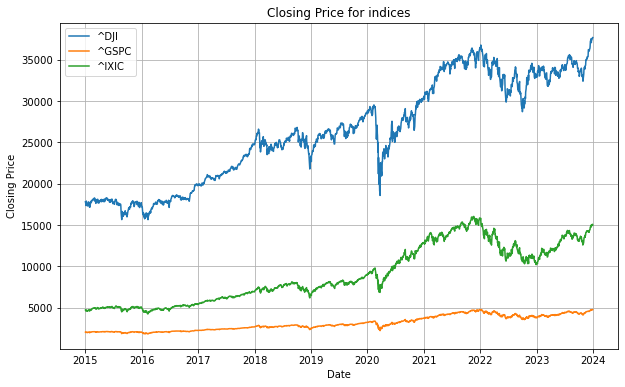

In [124]:
# Plot the closing price for each index
plt.figure(figsize=(10, 6))
for symbol in symbols:
    ticker_data = idx_data[idx_data['Index'] == symbol]
    plt.plot(ticker_data.index, ticker_data['Close'], label=symbol)

plt.title('Closing Price for indices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

Derive technical indicators or features

    1 Open  - The first price
    2 High - The highest price during the day
    3 Low - The lowest price during the day
    4 Close - The closing or last price
    5 Volume - # of shares traded
    6 SMA5 - Previous 5 days close price moving avergae
    7 SMA10 - Previous 10 days close price moving average
    8 EMA5 - Exponential moving average 5 day closing price
    9 RSI - Relative strength index
    10 ROC - Rate of change
    11 Upper band - Upper Band of Bollinger
    12 Lower band - Lower Band of Bollinger
    13 MP - Mean price
    14 TP - Typical price
    15 ADL - Accumulation Distribution Line
    16 ATR - Average True Range
  

In [152]:
# Compute technical indicators

# calculate simple moving avergae
def SMA(data, window):
    cname = 'SMA_' + str(window)
    data[cname] = data.groupby('Index')['Close'].rolling(window).mean().reset_index(0, drop=True)
    return data

# calcualte exponential moving avergae
def EWMA(data, window):
    cname = 'EMA_' + str(window)
    data[cname] = data.groupby('Index')['Close'].transform(lambda x: x.ewm(span=window,min_periods = window - 1).mean())
    return data

# calculate the Bollinger Bands 
def Bollinger_bands(data, window):
    data["MA"] = data.groupby('Index')['Close'].rolling(window).mean().reset_index(0, drop=True)
    data["SD"] = data.groupby('Index')['Close'].rolling(window).std().reset_index(0, drop=True)
    data['UpperBand'] = data["MA"] + (2 * data["SD"] ) 
    data['LowerBand'] = data["MA"] - (2 * data["SD"] )
    data = data.drop(['MA', 'SD'], axis=1)
    return data

# calculate rate of change
def ROC(data, window=1):
    def cal_ROC(df, window):
        roc = df['Close'].pct_change(periods=window)
        return roc.to_numpy()
    
    data['ROC'] = data.groupby('Index').apply(lambda x: cal_ROC(x, window)).reset_index(0, drop=True)
    
    return data

# calculate RSI values
def RSI(data, window):
    def cal_RSI(df,window):
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        
        return rsi.to_numpy()
    data['RSI'] = data.groupby('Index').apply(lambda x: cal_RSI(x, window)).reset_index(0, drop=True)
    
    return data

# calculate ATR

def ATR(data,window=14):
    def cal_ATR(df, n):
        high = df["High"]
        low = df["Low"]
        close = df["Close"]
        tr = np.amax(np.vstack(((high - low).to_numpy(), (abs(high - close)).to_numpy(), (abs(low - close)).to_numpy())).T, axis=1)

        return pd.Series(tr).rolling(n).mean().to_numpy()
    
    data['ATR'] = data.groupby('Index').apply(lambda x: cal_ATR(x, window)).reset_index(0, drop=True)
    
    return data 

In [153]:
idx_data["MeanPx"] =  (idx_data["High"] + idx_data["Low"]  ) / 2
idx_data["TypicalPx"] = (idx_data["High"] + idx_data["Low"] + idx_data["Close"]  ) / 3
idx_data = SMA(idx_data,5)
idx_data = SMA(idx_data,10)
idx_data = EWMA(idx_data,5)
idx_data = Bollinger_bands(idx_data,20)
idx_data = RSI(idx_data,20)
idx_data = ATR(idx_data)
idx_data = ROC(idx_data)

In [154]:
idx_data[idx_data["Index"] == "^GSPC"].head()

,Open,High,Low,Close,Adj Close,Volume,Index,MeanPx,TypicalPx,SMA_5,SMA_10,EMA_5,UpperBand,LowerBand,ATR,RSI_,RSI,ROC
Date,,,,,,,,,,,,,,,,,,
2015-01-02,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000,^GSPC,2059.200073,2058.866699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,2054.439941,2054.439941,2017.339966,2020.579956,2020.579956,3799120000,^GSPC,2035.889954,2030.786621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,2022.150024,2030.250000,1992.439941,2002.609985,2002.609985,4460110000,^GSPC,2011.344971,2008.433309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,2005.550049,2029.609985,2005.550049,2025.900024,2025.900024,3805480000,^GSPC,2017.580017,2020.353353,NaN,NaN,2022.443684,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,2030.609985,2064.080078,2030.609985,2062.139893,2062.139893,3934010000,^GSPC,2047.345032,2052.276652,2033.885962,NaN,2037.682513,NaN,NaN,NaN,NaN,NaN,NaN
